# Preprocessing 

1) Import and remove corrupt/inconsistant/unnecessary data

2) Drop cols. with >60% missing data (nan values) 

3) Remove highly corrilated features with corrilation above 70%

4) Change target variable 'pick' to 1 if value is 1-60, else to 0

5) Merge each individual player into 1 row/player

6) Remove all players who still have >15% missing data 

7) split into training and testing data

8) Use KNN to fill in any remaining missing data/Nan values

9) Feature selection with random forest classifier 



In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import warnings
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, GridSearchCV,HalvingRandomSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn import metrics, preprocessing
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score


In [2]:
playerDf = pd.read_csv('data/CollegeBasketballPlayers2009-2021.csv', low_memory=False)

#initial dropping of inconsistant data for player data 
playerDf = playerDf.rename(columns = {'Unnamed: 64' : 'role_position'})
playerDf = playerDf.drop('Unnamed: 65', axis=1) # Has no meaning in the dataset
playerDf = playerDf.drop('ht', axis=1) # Temporarily excluding this column due to inconsistent date formats and other values
playerDf = playerDf.drop('num', axis=1) # It might denote a player's choice or position but with significant variation in meaning.
playerDf = playerDf.drop('type', axis=1) # Column has 1 unique value
playerDf= playerDf.drop('pid', axis=1) # catigorical, not needed 
playerDf= playerDf.drop('yr', axis=1) # catigorical, not needed 

print(playerDf.shape)

(61061, 60)


In [3]:
# Count and remove columns with over 60% nan values from players
total = len(playerDf)
for column in playerDf.columns:
    count = playerDf[column].isna().sum()
    percent= (count/ total) * 100
    if (percent>=60):
        print(f"Player  DF: Column '{column}':", f"Number of NaN: {count}", f"Percentage: {percent:.2f}%")

Player  DF: Column 'Rec Rank': Number of NaN: 42591 Percentage: 69.75%
Player  DF: Column 'pick': Number of NaN: 59626 Percentage: 97.65%


In [4]:
playerDf = playerDf.drop('Rec Rank', axis=1) 

In [5]:
#remove redundant/highly corrilated data 
player_corr_matrix = playerDf.corr()
correlation_threshold = 0.95
corr_df = playerDf.corr().abs()
mask = np.triu(np.ones_like(corr_df, dtype=bool))
tri_df = corr_df.mask(mask)

# Find columns that meet threshold
features_to_drop = [c for c in tri_df.columns if any(tri_df[c] >= correlation_threshold)]
print(features_to_drop)

C:\Users\joshk\AppData\Local\Temp\ipykernel_12644\1290011257.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  player_corr_matrix = playerDf.corr()
C:\Users\joshk\AppData\Local\Temp\ipykernel_12644\1290011257.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_df = playerDf.corr().abs()


['Min_per', 'Ortg', 'FTM', 'twoPM', 'TPM', 'rimmade', 'midmade', 'dunksmade', 'dreb']


In [6]:
# Remove the highly correlated features from the DataFrame
playerDf = playerDf.drop(columns=features_to_drop, axis=1)

# Display the new shape of the DataFrame
print("Shape of the DataFrame after removing highly correlated features:", playerDf.shape)

Shape of the DataFrame after removing highly correlated features: (61061, 50)


In [7]:
#if drafted, change to 1 since values for drafted are 1-60 and not drafted is saved as nan
playerDf.loc[playerDf["pick"] > 0, "pick"] = 1
#not drafted was nan, replace with 0 
playerDf.loc[playerDf["pick"] != 1, "pick"] = 0

In [8]:
#merge the players so 1 player/row
categorical_columns = ['player_name', 'team', 'role_position', 'conf']

# Function to calculate weighted average
def weighted_avg(group):
    categorical_data = group.iloc[-1, group.columns.isin(categorical_columns)]
    data_to_ave = group.drop(columns=categorical_columns).mean(numeric_only=True)
    
    if any(group['pick'] == 1):
        group['pick'] = 1
    return pd.concat([categorical_data, data_to_ave])

# Group by player name and team, then apply weighted average
playerDf['player_name'] = playerDf['player_name'].str.lower()
player_grouped = playerDf.groupby(['player_name', 'team'], as_index=False).apply(weighted_avg)
player_grouped.reset_index(drop=True, inplace=True)

In [9]:
print(playerDf.shape)
print(player_grouped.shape)

(61061, 50)
(30200, 50)


In [10]:
#don't need name anymore 
player_grouped = player_grouped.drop('player_name', axis=1) 
playerDf=player_grouped

In [11]:
#drop any players who still have >15% missing values 
threshold = 15
missing_percentage = (playerDf.isnull().sum(axis=1) / playerDf.shape[1]) * 100
rows_to_drop = []

for index, percentage in missing_percentage.items():
    if percentage > threshold:
        rows_to_drop.append(index)

playerDf = playerDf.drop(index=rows_to_drop)


In [12]:
#Encode catigorical data 
team_label_encoder = LabelEncoder()
playerDf['team'] = team_label_encoder.fit_transform(playerDf['team'])

conf_label_encoder = LabelEncoder()
playerDf['conf'] = conf_label_encoder.fit_transform(playerDf['conf'])

role_position_label_encoder = LabelEncoder()
playerDf['role_position'] = role_position_label_encoder.fit_transform(playerDf['role_position'])


In [13]:
#split into training and testing data to avoid any overlap 
trainDf=playerDf.loc[playerDf['year'] <2021]
testDf= playerDf.loc[playerDf['year'] >= 2021]

In [14]:
print(trainDf.shape)
print(testDf.shape)

(27462, 49)
(2527, 49)


In [15]:
#KNN fill in NAN values 
def fillNan(df):
    imputer = KNNImputer(n_neighbors=11)
    imputed_numeric = imputer.fit_transform(df.select_dtypes(include=np.number))
    dfBasketballTraining_filled = pd.DataFrame(imputed_numeric, columns=df.select_dtypes(include=np.number).columns)

    string_columns = df.select_dtypes(include='object').columns
    imputed_data = pd.concat([df[string_columns].reset_index(drop=True), dfBasketballTraining_filled], axis=1)

    return pd.DataFrame(imputed_data, columns=df.columns)

In [16]:
trainDf=fillNan(trainDf)
testDf=fillNan(testDf)

In [17]:
#Scale data  
def scaleData(df):
    exclude=['team', 'conf', 'year', 'role_position', 'pick']
    colToScale= [col for col in df.columns if col not in exclude]
    
    scaler = StandardScaler()
    scaledData = df.copy()  
    scaledData[colToScale] = scaler.fit_transform(df[colToScale])
    
    return pd.DataFrame(scaledData, columns=df.columns) 

In [18]:
trainDf=scaleData(trainDf)
testDf=scaleData(testDf)

In [19]:
#feature selection with random forest 
X = trainDf.drop("pick", axis=1)
y = trainDf["pick"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit a RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100)
rf_classifier.fit(X_train, y_train)

#importance
sel = SelectFromModel(rf_classifier)
sel.fit(X_train, y_train)

# Get support and selected feature names
selected_feature_indices = sel.get_support()
selected_features = X_train.columns[selected_feature_indices]

print("Selected features:")
print(selected_features)

print("Feature importance scores:")
print(sel.estimator_.feature_importances_)


Selected features:
Index(['GP', 'twoPA', 'porpag', 'adjoe', 'midmade+midmiss',
       'dunksmiss+dunksmade', 'adrtg', 'dporpag', 'stops', 'bpm', 'obpm',
       'gbpm', 'ogbpm', 'pts'],
      dtype='object')
Feature importance scores:
[0.01510635 0.0125381  0.0053867  0.02772262 0.01520091 0.01225151
 0.0133716  0.01117966 0.01380057 0.01309693 0.01544391 0.01833696
 0.01386437 0.02379051 0.01219302 0.01372305 0.01082903 0.01258047
 0.01247102 0.01256495 0.03593986 0.03450695 0.01210924 0.00978605
 0.0156857  0.02056887 0.02358549 0.0182079  0.01346155 0.038278
 0.01228887 0.01824181 0.03670815 0.06747227 0.03987794 0.05263042
 0.0254149  0.01985548 0.05568875 0.01867065 0.03046465 0.01862918
 0.01301714 0.017273   0.01294539 0.01460204 0.01598204 0.02265548]


# Model 

1) Model: first tested training with k-fold cross validation 

2) Model: second tested training by balancing data 

## Model: training with k-fold cross validation

In [20]:
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def train(model, data, features, target='pick', n_splits=10):
    data = data.sample(frac=1, random_state=42).reset_index(drop=True)
    
    train_scores = {'k': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1 Score': []}
    val_scores = {'k': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1 Score': []}
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for i, (train_index, test_index) in enumerate(kf.split(data)):
        train_set = data.iloc[train_index]
        test_set = data.iloc[test_index]

        train_X, train_y = train_set[features], train_set[target]
        test_X, test_y = test_set[features], test_set[target]

        # Assuming you have an instantiated model
        model.fit(train_X, train_y)
        
        train_predictions = model.predict(train_X)
        val_predictions = model.predict(test_X)
        
        # Evaluate metrics for training set
        train_accuracy = accuracy_score(train_y, train_predictions)
        train_precision = precision_score(train_y, train_predictions)
        train_recall = recall_score(train_y, train_predictions)
        train_f1 = f1_score(train_y, train_predictions)
        
        # Store metrics for later analysis
        train_scores['k'].append(i+1)
        train_scores['Accuracy'].append(train_accuracy)
        train_scores['Precision'].append(train_precision)
        train_scores['Recall'].append(train_recall)
        train_scores['F1 Score'].append(train_f1)

        # Evaluate metrics for validation set
        val_accuracy = accuracy_score(test_y, val_predictions)
        val_precision = precision_score(test_y, val_predictions)
        val_recall = recall_score(test_y, val_predictions)
        val_f1 = f1_score(test_y, val_predictions)
        
        # Store metrics for later analysis
        val_scores['k'].append(i+1)
        val_scores['Accuracy'].append(val_accuracy)
        val_scores['Precision'].append(val_precision)
        val_scores['Recall'].append(val_recall)
        val_scores['F1 Score'].append(val_f1)
        

    # Calculate average metrics across all folds for training set
    avg_train_precision = np.mean(train_scores['Precision'])
    avg_train_recall = np.mean(train_scores['Recall'])
    avg_train_f1 = np.mean(train_scores['F1 Score'])
    avg_train_accuracy = np.mean(train_scores['Accuracy'])

    # Calculate average metrics across all folds for validation set
    avg_val_precision = np.mean(val_scores['Precision'])
    avg_val_recall = np.mean(val_scores['Recall'])
    avg_val_f1 = np.mean(val_scores['F1 Score'])
    avg_val_accuracy = np.mean(val_scores['Accuracy'])

    print(f"[Train] Average Accuracy: {avg_train_accuracy}")
    print(f"[Train] Average Precision: {avg_train_precision}")
    print(f"[Train] Average Recall: {avg_train_recall}")
    print(f"[Train] Average F1 Score: {avg_train_f1}")

    print(f"[Validation] Average Accuracy: {avg_val_accuracy}")
    print(f"[Validation] Average Precision: {avg_val_precision}")
    print(f"[Validation] Average Recall: {avg_val_recall}")
    print(f"[Validation] Average F1 Score: {avg_val_f1}")
    
    return train_scores, val_scores

In [21]:
features=['porpag','adjoe','adrtg', 'bpm', 'obpm', 'dbpm', 'ogbpm', 'dgbpm', 'pts']
# features=selected_features
# features=['usg', 'DRB_per', 'AST_per', 'TO_per', 'twoP_per', 'blk_per', 'porpag','bpm', 'dbpm', 'ogbpm', 'dgbpm']
# features= [ 'treb', 'ast','stl', 'blk', 'pts']

In [22]:
#citations: 
#video: https://aleksandarhaber.com/ensemble-learning-in-scikit-learn-voting-classifiers/
#Documentation: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
#build model 

#the 3 models for the ensemble 
logreg = LogisticRegression(class_weight="balanced", multi_class='multinomial', max_iter=2000, random_state=42)
randFor = RandomForestClassifier(class_weight="balanced_subsample", n_estimators=60, random_state=42)
svm = SVC(probability=True, random_state=42)
                       
# voting ensemble classifier 
model = VotingClassifier(n_jobs=-1, estimators=[('lr', logreg), ('rf', randFor), ('svm', svm)], voting='soft')

train_metrics, val_metrics = train(model, trainDf, features, n_splits=10)

[Train] Average Accuracy: 0.9916814331051607
[Train] Average Precision: 0.8632265622850639
[Train] Average Recall: 0.7715955559768993
[Train] Average F1 Score: 0.8147475895189176
[Validation] Average Accuracy: 0.9794260626238357
[Validation] Average Precision: 0.6096724815021355
[Validation] Average Recall: 0.38394521450172875
[Validation] Average F1 Score: 0.4663094688675241


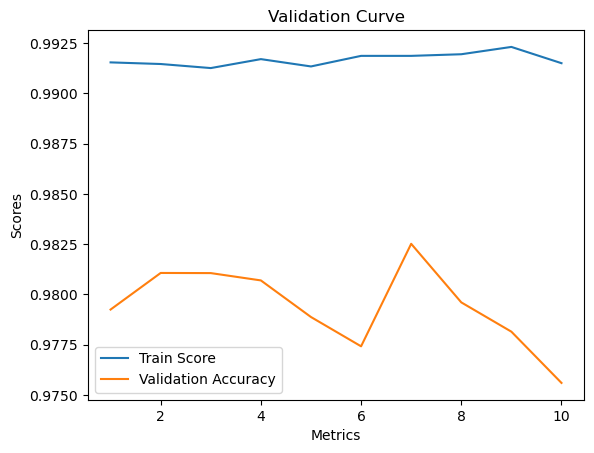

In [23]:
fig, ax = plt.subplots()

plt.plot(train_metrics['k'], train_metrics['Accuracy'], label='Train Score')
plt.plot(val_metrics['k'], val_metrics['Accuracy'], label='Validation Accuracy')

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Validation Curve')
ax.legend()

plt.show()

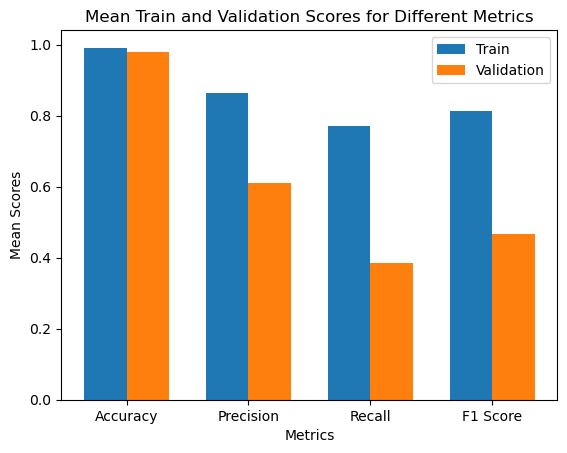

In [24]:
train_means = [np.mean(train_metrics['Accuracy']),
               np.mean(train_metrics['Precision']),
               np.mean(train_metrics['Recall']),
               np.mean(train_metrics['F1 Score'])]

val_means = [np.mean(val_metrics['Accuracy']),
             np.mean(val_metrics['Precision']),
             np.mean(val_metrics['Recall']),
             np.mean(val_metrics['F1 Score'])]

labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
bar_width = 0.35
index = np.arange(len(labels))

fig, ax = plt.subplots()
bar1 = ax.bar(index, train_means, bar_width, label='Train')
bar2 = ax.bar(index + bar_width, val_means, bar_width, label='Validation')

ax.set_xlabel('Metrics')
ax.set_ylabel('Mean Scores')
ax.set_title('Mean Train and Validation Scores for Different Metrics')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

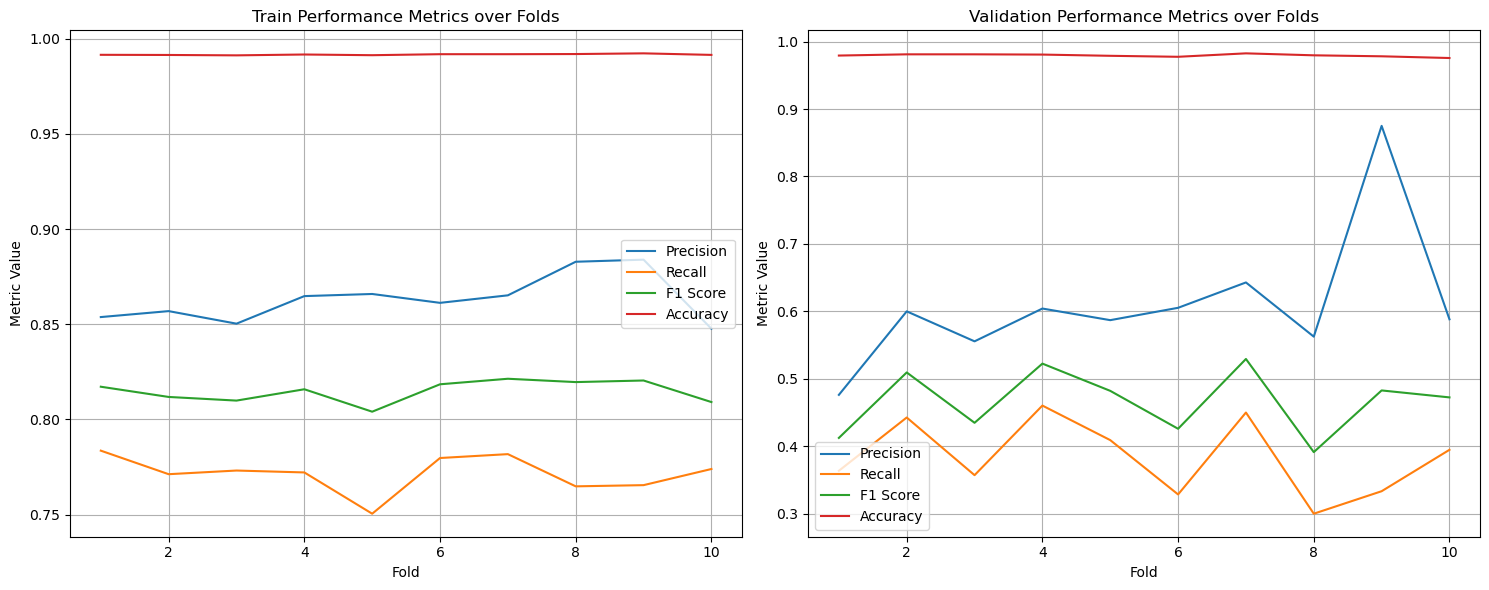

In [25]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot for train_metrics
ax1.plot(train_metrics['k'], train_metrics['Precision'], label='Precision')
ax1.plot(train_metrics['k'], train_metrics['Recall'], label='Recall')
ax1.plot(train_metrics['k'], train_metrics['F1 Score'], label='F1 Score')
ax1.plot(train_metrics['k'], train_metrics['Accuracy'], label='Accuracy')

# Customize the plot for train_metrics
ax1.set_title('Train Performance Metrics over Folds')
ax1.set_xlabel('Fold')
ax1.set_ylabel('Metric Value')
ax1.legend()
ax1.grid(True)

# Plot for test_metrics
ax2.plot(val_metrics['k'], val_metrics['Precision'], label='Precision')
ax2.plot(val_metrics['k'], val_metrics['Recall'], label='Recall')
ax2.plot(val_metrics['k'], val_metrics['F1 Score'], label='F1 Score')
ax2.plot(val_metrics['k'], val_metrics['Accuracy'], label='Accuracy')

# Customize the plot for test_metrics
ax2.set_title('Validation Performance Metrics over Folds')
ax2.set_xlabel('Fold')
ax2.set_ylabel('Metric Value')
ax2.legend()
ax2.grid(True)

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plot
plt.show()

In [26]:
#test the model 
test_X, test_y = testDf[features], testDf['pick']

# Predict if player was selected for the draft on the test set
y_pred_test = model.predict(test_X)

#preformance metrics for test set
accuracy = accuracy_score(test_y, y_pred_test)
precision = precision_score(test_y, y_pred_test)
recall = recall_score(test_y, y_pred_test)
f1 = f1_score(test_y, y_pred_test)

print('[Test] Accuracy:', accuracy)
print('[Test] Precision:', precision)
print('[Test] Recall:', recall)
print('[Test] F1-score:', f1)

[Test] Accuracy: 0.9908982983775227
[Test] Precision: 0.44
[Test] Recall: 0.55
[Test] F1-score: 0.48888888888888893


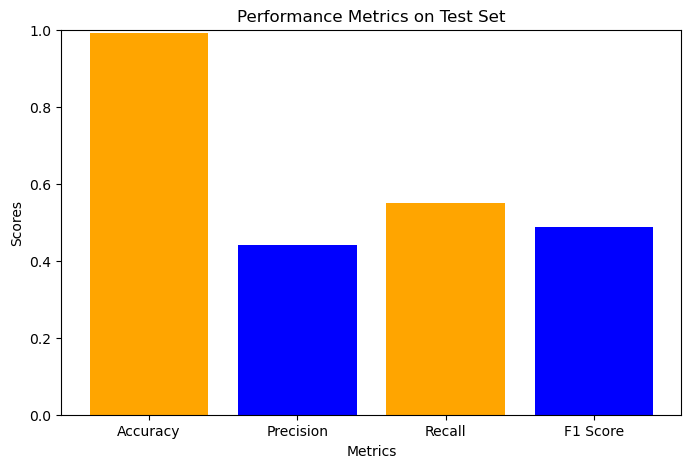

In [27]:
#plot testing 
metrics = ['Accuracy','Precision', 'Recall', 'F1 Score']
scores = [accuracy, precision, recall , f1]

plt.figure(figsize=(8, 5))
plt.bar(metrics, scores, color=['orange','blue', 'orange', 'blue'])
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Performance Metrics on Test Set')
plt.ylim(0, 1)
plt.show()

## Test run pref values for cross fold and various features selected:

1) 5 training sets, features = ['GP', 'FTA', 'porpag', 'adjoe', 'adrtg', 'bpm', 'obpm', 'dbpm', 'blk', 'pts']
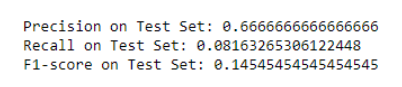

2) 5 training sets, features=['usg', 'DRB_per', 'AST_per', 'TO_per',  'twoP_per', 'blk_per', 'porpag','bpm', 'dbpm', 'ogbpm', 'dgbpm']

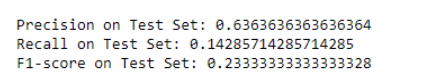

3) 5 training sets, features=['porpag', 'adjoe','adrtg', 'bpm', 'obpm', 'dbpm', 'ogbpm', 'dgbpm', 'pts']

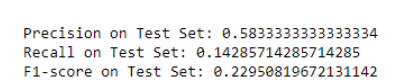

## best
4) 6 training sets, features=['porpag','adjoe','adrtg', 'bpm', 'obpm', 'dbpm', 'ogbpm', 'dgbpm', 'pts']

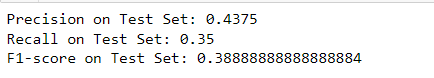

5) 6 training sets, features=['conf', 'role_position','rimmade/(rimmade+rimmiss)', 'midmade/(midmade+midmiss)',
       'dunksmiss+dunksmade', 'dunksmade/(dunksmade+dunksmiss)', 'ast','stl', 'blk']

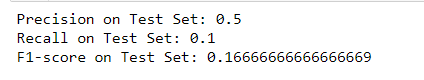

6) 6 training sets,  features=[ 'treb', 'ast','stl', 'blk', 'pts']

0's across the board 


Conclusion, aggrigated data values 'porpag','adjoe','adrtg', 'bpm', 'obpm', 'dbpm', 'ogbpm', 'dgbpm' as well as 'pts' are best predictors. Knowing how the agrigated values are found can help players understand what areas they need to improve to increase odd of being drafted.


## Model: training with semi balanced data

In [28]:

def kFoldTrain(model, sets, features, target='pick'):
    prefMetrics = {'Validation set': [], 'Precision': [], 'Recall': [], 'F1 Score': []}
    correctPred = 0
    totalPred = 0

    for j in range(len(sets)):
        valSet = sets[j]
        
        for i in range(len(sets)):
            # Don't train validation set against the validation set 
            if i != j:
                # Remove the target variable pick from the training and testing data 
                trainSet = sets[i]
                trainNoTarget = trainSet[features]
                trainTarget = trainSet[target]
                valNoTarget = valSet[features]
                valTarget = valSet[target]
                
                model.fit(trainNoTarget, trainTarget)
                
                # Make predictions with the validation set 
                predVals = model.predict(valNoTarget)

                # Calculate metrics
                prefMetrics['Validation set'].append(j+1)
                prefMetrics['Precision'].append(precision_score(valTarget, predVals))
                prefMetrics['Recall'].append(recall_score(valTarget, predVals))
                prefMetrics['F1 Score'].append(f1_score(valTarget, predVals))

                # Update correct predictions and total predictions for expected preformance accuracy 
                correctPred += np.sum(predVals == valTarget)
                totalPred += len(valTarget)

    expAccuracy = correctPred / totalPred

    return expAccuracy, prefMetrics
                

In [29]:
def get_training_data(dataframe, existing_data, replacement):
    notDraftedCount = 200
    drafted = int(notDraftedCount*0.10)
    
    not_drafted_mask = (dataframe['pick'] == 0) & (~dataframe.isin(existing_data).all(axis=1))
    drafted_mask = (dataframe['pick'] == 1) & (~dataframe.isin(existing_data).all(axis=1))
    
    not_drafted = dataframe[not_drafted_mask].sample(n=notDraftedCount, replace=replacement)
    drafted = dataframe[drafted_mask].sample(n=drafted, replace=replacement)
    
    not_drafted = not_drafted.drop_duplicates().reset_index(drop=True)
    drafted = drafted.drop_duplicates().reset_index(drop=True)
    
    return not_drafted, drafted

In [30]:
def get_sets():
    trainingSets = []
    existing_data = pd.DataFrame()

    for i in range(10):
        not_drafted, drafted = get_training_data(trainDf, existing_data, False)
        existing_data = pd.concat([existing_data, not_drafted, drafted], ignore_index=True)
        trainingSets.append(pd.concat([not_drafted, drafted], ignore_index=True).copy())
    return trainingSets

In [31]:
def run_training(t):
    logreg = LogisticRegression(multi_class='multinomial', max_iter=2000, random_state=42)
    randFor = RandomForestClassifier(n_estimators=73, random_state=109)
    svm = SVC(probability=True, random_state=42) 


    # voting ensemble classifier 
    model = VotingClassifier(estimators=[('lr', logreg), ('rf', randFor), ('svm', svm)], voting='soft')

    features=['porpag','adjoe','adrtg', 'bpm', 'obpm', 'dbpm', 'ogbpm', 'dgbpm', 'pts']
    # voting ensemble classifier 

    ExpAccuracy,trainMetrics=kFoldTrain(model, t, features)
    metricDf=pd.DataFrame(trainMetrics)
    return ExpAccuracy, metricDf, model

In [32]:
def train_stats(ExpAccuracy, metricDf):
    print("Accuracy estimate for the model: ", ExpAccuracy)
    print("Precision estimate for the model: ", metricDf['Precision'].mean())
    print("Recall estimate for the model: ", metricDf['Recall'].mean())
    print("F1 Score estimate for the model: ", metricDf['F1 Score'].mean())

In [33]:
def test_training(model):
    #test the model 
    testNoPick=testDf[features]
    testPick=testDf['pick']

    # Predict if player was selected for the draft on the test set
    predTest = model.predict(testNoPick)

    #preformance metrics for test set
    tPrecision = precision_score(testPick, predTest)
    tRecall = recall_score(testPick, predTest)
    tF1 = f1_score(testPick, predTest)
    tAccuracy = accuracy_score(testPick, predTest)
    return tPrecision, tRecall, tF1, tAccuracy

In [34]:
def print_test(tPrecision, tRecall, tF1, tAccuracy):
    print('Accuracy on Test Set:', tAccuracy)
    print('Precision on Test Set:', tPrecision)
    print('Recall on Test Set:', tRecall)
    print('F1-score on Test Set:', tF1)

In [35]:
c = 0
while(c < 0.33):
    t = get_sets()
    x, y, m = run_training(t)
    a, b, c, d = test_training(m)
train_stats(x, y)
print_test(a, b, c, d)

Accuracy estimate for the model:  0.9395959595959597
Precision estimate for the model:  0.721706619536109
Recall estimate for the model:  0.55
F1 Score estimate for the model:  0.6160062663184857
Accuracy on Test Set: 0.9817965967550455
Precision on Test Set: 0.24
Recall on Test Set: 0.6
F1-score on Test Set: 0.34285714285714286


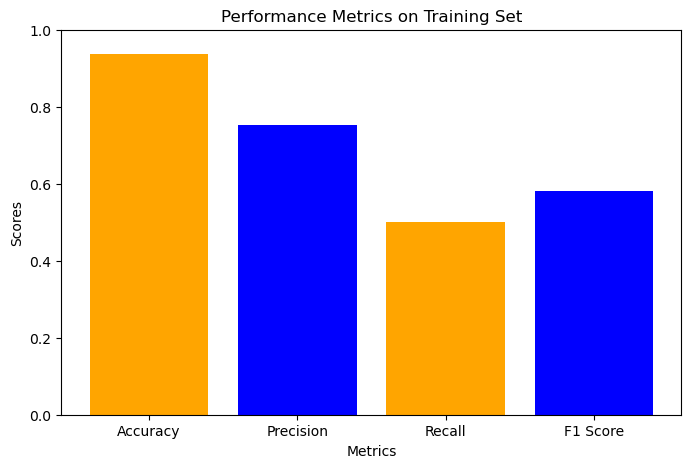

In [36]:
#plot testing 
metrics = ['Accuracy','Precision', 'Recall', 'F1 Score']
scores = [0.9377777777777778, 0.7527172042497118,  0.5 , 0.580708919861887]

plt.figure(figsize=(8, 5))
plt.bar(metrics, scores, color=['orange','blue', 'orange', 'blue'])
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Performance Metrics on Training Set')
plt.ylim(0, 1)
plt.show()

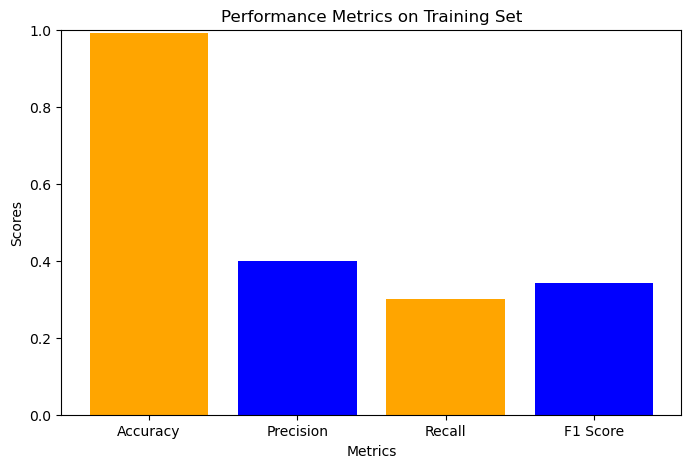

In [37]:
#plot testing 
metrics = ['Accuracy','Precision', 'Recall', 'F1 Score']
scores = [0.9904524699045247, 0.4,  0.3 , 0.34285714285714286]

plt.figure(figsize=(8, 5))
plt.bar(metrics, scores, color=['orange','blue', 'orange', 'blue'])
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Performance Metrics on Training Set')
plt.ylim(0, 1)
plt.show()